# Исследовательский проект "Отток клиентов"

## Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

### Цель проекта
Создать модель, которая на основании исследования исторических данных о поведении клиентов и фактах расторжения договоров с банком предсказывает, уйдёт клиент из банка в ближайшее время или нет. Показателем качества модели принять F1-меру , которая не должна быть хуже 0.59. 

### Задачи проекта
1. Построить модель классификации для предсказания поведения клиента (уйдет, не уйдет)
2. Довести метрику качества модели (F1-меру) до 0.59.
3. Дополнительно отслеживать прказатель метрики AUC-ROC, сравнивая её значение с F1-мерой

### Этапы проекта
1. Исследование данных
 - загрузка данных
 - оценка данных (формы, типов, смысловой нагрузки)
 
2. Предъобработка данных
 - проверка и переименование названий столбцов
 - проверка корректноти назначенных типов данных
 - проверка и заполнение пропусков
 - выявление аномальных значений
 - добавление категориальных переменных и стратификация (при необходимости)
 - разбиение данных на тренировочную, валидационную и тестовую выборки
 
3. Исследование данных на предмет применимости для машинного обучения
  - изучение признаков и целевых показателей
  - исследование балланса классов
  - нормализация данных
  - исключение дсбаланса 
     - за счет добавления значений
     - за счет уменьшения значений 
  
  4. Машинное обучение с учителем
   - обучение модели без учета дисбаланса
   - обучение модели с учетом дисбаланса
   - обучение нескольких вариантов моделей с учетом дисбаланса
   - выбор лучшей модели на основании метрик (F1-мера, AUC-ROC)
   - финальное тестирование лучшей модели
   - сравнение метрик, полученных на тестовой с заданным пороговым значением
   - итоговые выводы


### Описание данных
#### Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

#### Целевой признак
- Exited — факт ухода клиента

In [ ]:
# Подключение Google-disk
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Подготовка библиотек

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats

from itertools import combinations
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

In [ ]:
#Функция, которая рисует барплот для целевой переменной и расчитывает дисбаланс
def drow_target_bar(target):
  #Распределение значений целевого показателя
  fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
  fig.suptitle('Распределение целевой переменной', fontsize=14, fontweight='bold', y = 0.95);

  df = pd.DataFrame(target.value_counts(), index = target.value_counts().index)
  df.plot.bar(ax = axes)
  axes.set(xlabel = 'Ушел ли клиент ?')
  locs, labels = plt.xticks()  # Get the current locations and labels.
  plt.xticks(locs, ['Да', 'Нет'])  # Set text labels.

  # create a list to collect the plt.patches data
  totals = []

  # find the values and append to list
  for i in axes.patches:
    totals.append(i.get_height())

  # set individual bar lables using above list
  total = sum(totals)

  # set individual bar lables using above list
  for i in axes.patches:
    # get_x pulls left or right; get_height pushes up or down
    axes.text(i.get_x()+.19, i.get_height()+0.5, \
              str(round((i.get_height()/total)*100, 2))+'%', fontsize=13,
                color='dimgrey')
    
  disbalance = target.value_counts()[0]/target.value_counts()[1]
  print(f'Соотношение количества False записей записям True равно: {disbalance}')

In [ ]:
#Функция для подбора всех возможных комбинаций заданных параметров. 
#Принимает на вход словарь с параметрами, которые надо проверить 
#({'имя 1-го параметра': [список для перебора], 'имя 2-го параметра': [список для перебора]})
#Возбращает список со словарями со всеми возможными комбинациями 
#[{'имя 1-го параметра': значение 1-1, 'имя 2-го параметра': значение 2-1'},
#{'имя 1-го параметра': значение 1-2, 'имя 2-го параметра': значение 2-1'},]
def calc_param_comb(dict_with_params):
    all_values = []
    list_for_del = []
    
    #Формируем список всех параметров
    for key, list_with_param in tqdm(dict_with_params.items()):
        if not isinstance(list_with_param, list):
            list_with_param = [list_with_param,]
            dict_with_params[key] = list_with_param
        all_values.extend(list(list_with_param))
     
    #Просчитываем все возможные комбинации на основании полного множества    
    combinatin = set(combinations(all_values, len(dict_with_params)))
    
    #Формируем список комбинаций, в которых использованы комбинации, где 
    #на позициях использованы элементы, которых нет в спискахдля этой позиции
    for comb_item in tqdm(combinatin):
        for index_param, list_with_param in enumerate(dict_with_params.values()):
             if comb_item[index_param] not in list_with_param:
                list_for_del.append(comb_item)
    
    #Удаляем неправильные комбинации
    for list_fd in set(list_for_del):
        combinatin.remove(list_fd)
     
    #Формируем список словарей с параметрами, которые будем последовательно 
    #передавать на вход вызываемой функции 
    combinatin_dict_list = []
    for comb in combinatin:
        dict_list = {}
        for ind in range(len(dict_with_params)):
            prom_dict = {list(dict_with_params.keys())[ind]: comb[ind]}
            dict_list = {**dict_list, **prom_dict}
        combinatin_dict_list.append(dict_list)
   
    return combinatin_dict_list

In [ ]:
#Функция для вызова одного из методов для создания моделей предсказаний
#Принимает на вход объект метода и словарь вида
#({'имя 1-го параметра': значение, 'имя 2-го параметра': значение, ...})
def run_func(func, **kwargs):
    #Словарь параметров для методов, чтобы функция знала, какие параметры изымать из kwargs
    func_dict = {DecisionTreeClassifier: ['random_state', 'max_depth', 'min_samples_split', \
                                          'min_samples_leaf', 'criterion', 'splitter',\
                                          'max_features'], \
                 RandomForestClassifier: ['random_state', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'],\
                 KNeighborsClassifier: ['n_neighbors', 'leaf_size', 'p'],
                 LinearDiscriminantAnalysis: [],
                 GaussianNB: [],
                 SVC: ['kernel', 'degree', 'gamma', 'decision_function_shape'],
                 LogisticRegression: ['solver', 'max_iter'],
                }
     
    #Измаем из kwargs нужные для вызываемого метода параметры и записываем их в новый словарь. 
    final_kwargs = {param: kwargs.get(param) for param in func_dict[func]}
    #Возвращаем функцию, которой на вход передан параматр random_state и словарь с параметрами 
    return(func(**final_kwargs))

In [ ]:
#Функция, которая обучает принятую на вход модель, делает предсказание и вычисляет f1-меру
def munipul_model(model, _train_feachers, _train_target, _valid_feachers, _valid_target):
    #Обучаем модель
    model.fit(_train_feachers, _train_target)

    #Делаем предсазание на валидационной выборке
    valid_predict = model.predict(_valid_feachers)
    #Делаем предсазание на тренировочной выборке
    train_predict = model.predict(_train_feachers)
  
    #Вычисляем f1 на валидационной выборке
    f1_valid = f1_score(_valid_target, valid_predict)
    #Вычисляем f1 на тренировочной выборке
    f1_train = f1_score(_train_target, train_predict)
    
    auc_model = model
    #Вычисляем roc_auc на валидационной выборке
    auc_valid = roc_auc_score(_valid_target, auc_model.predict_proba(_valid_feachers)[:, 1])
    #Вычисляем roc_auc на валидационной выборке
    auc_train = roc_auc_score(_train_target, auc_model.predict_proba(_train_feachers)[:, 1])

    return (f1_train, f1_valid, auc_train, auc_valid)  

In [ ]:
#Функция, которая принимает на вход название метода для модели, обучающую выборку, выборку, на которой надо сделать предикт и
#словарь с параметрами, которые нужно перебрать 
#({'имя 1-го параметра': [список для перебора], 'имя 2-го параметра': [список для перебора]})
def find_best_model(model_func,\
                    _train_feachers, _train_target, _valid_feachers, _valid_target,\
                    type = '', report = None, **kwargs):
    max_f1 = 0 
    best_model = None
    best_f1_valid = 0
    best_f1_train = 0
    best_auc_valid = 0
    best_auc_train = 0
   
    #Расчитываем все возможные комбинации параметров
    combinations = calc_param_comb(kwargs)
 
    #Для каждой строим модель, комбинации расчитываем метрики 
    for comb in tqdm(combinations):
        model = run_func(model_func, **comb)
        (f1_train, f1_valid, auc_train, auc_valid) = \
        munipul_model(model, _train_feachers, _train_target, _valid_feachers, _valid_target)
          
        #Ищем лучшую модель
        if f1_valid > max_f1:
            max_f1 = f1_valid
            best_model = model
            best_f1_valid = f1_valid
            best_f1_train = f1_train
            best_auc_valid = auc_valid
            best_auc_train = auc_train
            
            best_params = comb
   
    print(f'''Лучщая модель исследуемого метода : {model_func} показала эффективность (f1):
    - на проверочной выборке {best_f1_valid:.3},
    - на тренировочной выборке {best_f1_train:.3} с параметрами {best_params} ''')
    
    if report:
        if type == 'valid_up':
            report[model_func]['f1_train_up'] = best_f1_train
            report[model_func]['f1_valid_up'] = best_f1_valid
            report[model_func]['auc_train_up'] = best_auc_train
            report[model_func]['auc_valid_up'] = best_auc_valid
        elif type == 'valid_du':
            report[model_func]['f1_train_du'] = best_f1_train
            report[model_func]['f1_valid_du'] = best_f1_valid
            report[model_func]['auc_train_du'] = best_auc_train
            report[model_func]['auc_valid_du'] = best_auc_valid
        elif type == 'valid_db':
            report[model_func]['f1_train_db'] = best_f1_train
            report[model_func]['f1_valid_db'] = best_f1_valid
            report[model_func]['auc_train_db'] = best_auc_train
            report[model_func]['auc_valid_db'] = best_auc_valid
        elif type == 'test':
            report[model_func]['f1_test'] = best_f1_valid
            report[model_func]['auc_test'] = best_auc_valid
            
 
    return (best_model, best_params)

In [ ]:
#Функция для подбора лучшего порога для расчета таргета из predict_proba
def calc_limit(model, _features, _target):
    max_f1 =0
    
    probabilities = model.predict_proba(_features)
    predicted_one = probabilities[:, 1]
    for limit in np.arange(0, 1, 0.005):
        predict = predicted_one > limit 
        
        recall = recall_score(_target, predict)
        precision = precision_score(_target, predict)
           
        if (precision + recall) != 0: 
            f1 =  2*recall*precision/(precision + recall)
        else:
            f1 = 0
             
        #Ищем лучший порог
        if f1 > max_f1:
            max_f1 = f1
            best_limit = limit
            best_f1 = f1
            best_predict = predict
    
    return (best_limit, best_f1)   

## Исследование данных
### Загрузка данных

In [ ]:
#Считывание данных
try:
  data = pd.read_csv("/datasets/Churn.csv")
except:
  data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Churn.csv")

#Размерность ДФ
print(data.shape)

#Фиксируем начальное количество строк в ДФ
init_len = data.shape[0]

(10000, 14)


### Оценка данных

В ДФ всего 10000 записей, состоящих из 14 столбцов. На этапе предработки допустимо удалить не более 10%, то есть не более 1000 записей.

In [ ]:
#Обзор данных
display(data.sample(5))

#Основные статистические характеристики
display(data.describe())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1687,1688,15589348,Le Grand,850,Spain,Male,37,4.0,137204.77,1,1,1,28865.59,0
3410,3411,15595937,Bruno,430,Germany,Male,36,1.0,138992.48,2,0,0,122373.42,0
929,930,15590876,Knupp,764,France,Female,24,7.0,106234.02,1,0,0,115676.38,0
890,891,15768104,Wright,788,Spain,Male,37,8.0,141541.25,1,0,0,66013.27,0
3716,3717,15699492,Lorenzo,665,Germany,Female,27,2.0,147435.96,1,0,0,187508.06,0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


В ДФ есть три столбца, которые неинформативны с точки зрения исследования: 
- RowNumber (номер строки), 
- Surname (фамилия)
- CustomerId (идентификатор клиента)

Вместе с тем по идентификатору клиента предположительно можно оценить период, в течении которого клиент является клиентом банка (для тех, клиентов, которые еще не ушли из банка). 

In [ ]:
#Информация по структуре колонок ДФ
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

В структуре ДФ очевидно есть следующие проблемы:
 - не соотвествующий общепринятым практикам формат названий столбцов
 - стобецs HasCrCard, IsActiveMember, Exited  по смыслу должны иметь тип bool
 - в столбце Tenure есть пропущенные значения
 - в столбце EstimatedSalary очевидно есть аномальные (ошибочные) значения, так как зафиксированный min доход нереально маленький

## Предъобработка данных

 - проверка и переименование названий столбцов
 - корректировка типов данных
 - проверка и заполнение пропусков
 - выявление аномальных значений
 - добавление категориальных переменных и стратификация (при необходимости)
 - разбиение данных на тренировочную, валидационную и тестовую выборки

### Переименование столбцов 

In [ ]:
data.columns =  [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in data.columns]

In [ ]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

### Проверка дубликатов

In [ ]:
data.nunique()

row_number          10000
customer_id         10000
surname              2932
credit_score          460
geography               3
gender                  2
age                    70
tenure                 11
balance              6382
num_of_products         4
has_cr_card             2
is_active_member        2
estimated_salary     9999
exited                  2
dtype: int64

Во всех столбцах ДФ есть дубликаты, но не во всех столбцах это ожидаемо. Логично предположить, что значения в столбцах row_number и customer_id должны быть уникальными. Удалим строки, с дублирующимися значениями в этих столбцах

In [ ]:
data = data.drop_duplicates(subset = ['row_number','customer_id'], keep='first')
print(f'На данном этапе отброшено {100*(1 - (data.shape[0]/init_len))} % записей ')

На данном этапе отброшено 0.0 % записей 


ВЫведем списки уникальных значений для столбцов, где могут появится неявные дубликаты (geography, gender)

In [ ]:
print(data.geography.unique())
print(data.gender.unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


Неявных дубликатов в ДФ не обнаружено

### Проверка и заполнение пропусков

In [ ]:
data.tenure.isna().sum()

909

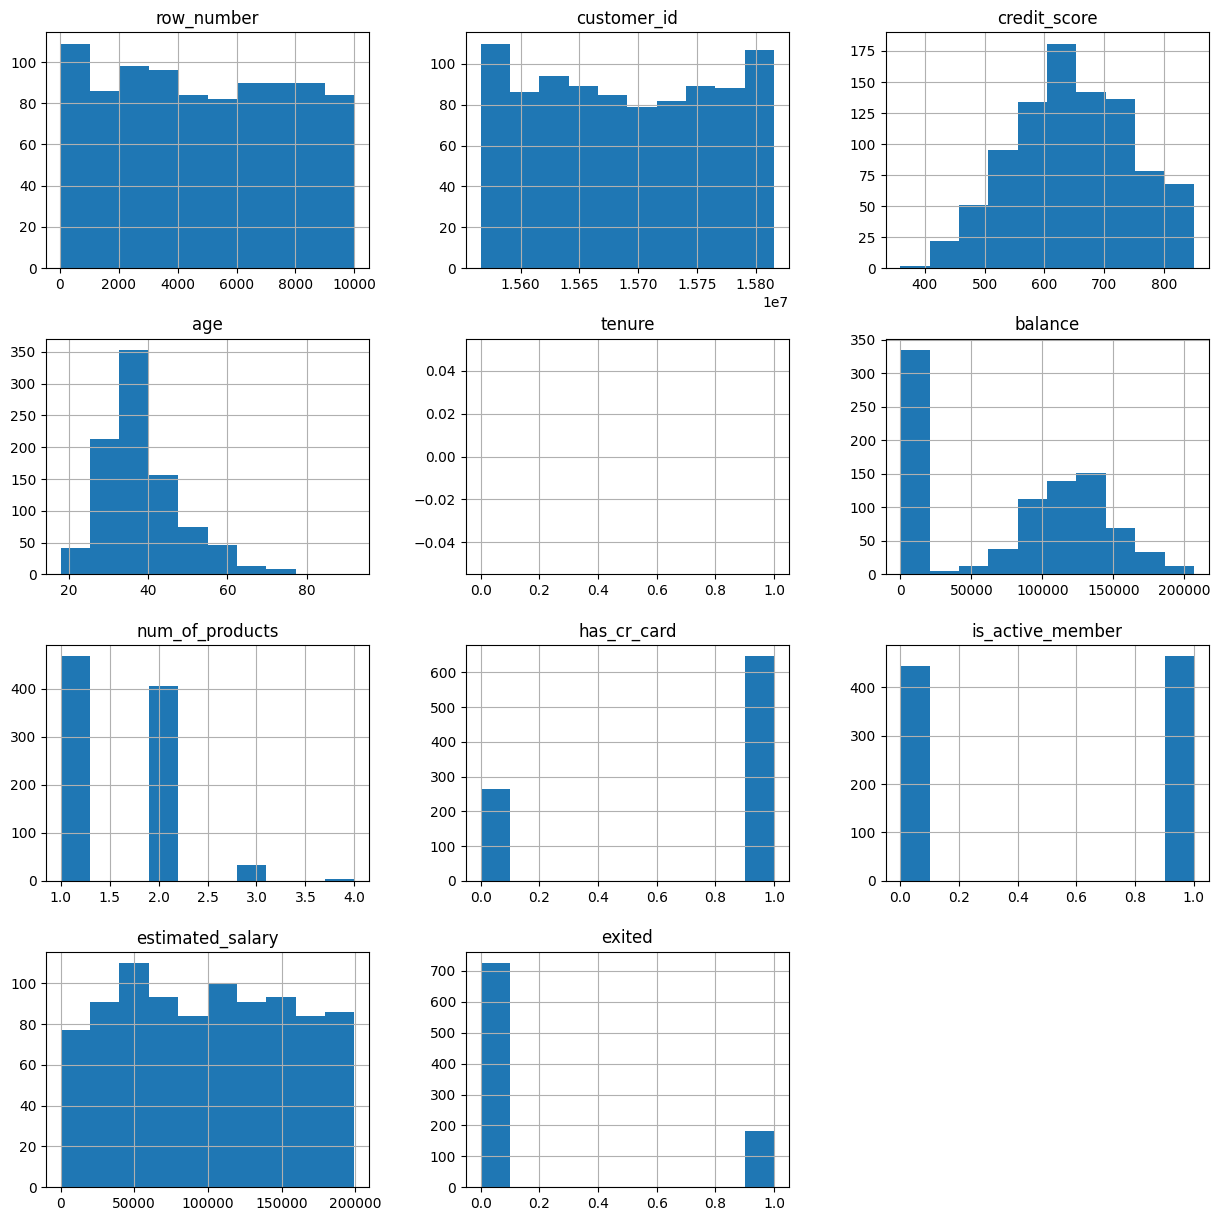

In [ ]:
data.query('tenure.isna()').hist(figsize = (15,15));

В датасете присутствует 909 записей, в которых пропущены значения для длительности срока действия договора клиента с банком (далее - длительность жизненного цикла, tenure). Среди которых примерно в 9% случаев клиенты ушли из банка (exited = 1), а в 91% - нет.

Очевидно, что длительность жизненного цикла - крайне важный признак, который предпооложительно должен иметь сильную связь с целевой переменной. Соответственно, крайне желательно максимально точно и максимально полно восстановить его пропущенные значения.

Допустим (*вообще конечно правильность этого предположения необходимо уточнить у заказчика*), что:
- client_id генерируется и выдается тогда, когда человек становиться клиентом и строго последовательно;
- каждый следующий клиент имеет client_id на 1 больший предыдущего;
- моменты времени, в которые люди стали клиентами у ближащих  client_id близки друг к другу;

Основываясь на указанных предположениях можно заключить, что в любой момент времени после оформления договора и до его расторжения длительности жизненного цикла клиентов с близкими client_id примерно равны. Исходя из чего представляется разумным применить следующую стратегию обработки пропущенных значений в стобце tenure:
1. Записи с пустым tenure, у которых exited == 0  заменим медианами по групам из 200 клиентов с client_id, ближайшими к рассматриваемому client_id.
2. Записи с пустым tenure, у которых exited == 1  заменим величинами, случайно взятыми из выборки всех ненулевых значений tenure.
3. Проверим гипотезу полученная после заполнения пропусков в tenure выборка и начальная выборка получены из одной генеральной совокупности.  

In [ ]:
data['new_tenure'] = data.tenure.copy()
#Заполнение пропусков медианами
client_id_list = data.query('tenure.isna() and exited == 0').customer_id

for client_id in client_id_list:
    sibling_ids = [id_value for id_value in range(client_id - 100, client_id + 100, 1)]
    if data.query('customer_id in @sibling_ids and exited == 0').new_tenure.mean():
      data.loc[data.customer_id == client_id, 'new_tenure'] = data.query('customer_id in @sibling_ids and exited == 0').new_tenure.mean()

#Заполнение оставшихся пропусков случайными значениями
client_id_list = data.query('new_tenure.isna()').customer_id

#Заполнение пропусков
for idx, client_id in enumerate(client_id_list):
    data.loc[data.customer_id == client_id, 'new_tenure'] = data.query('new_tenure.notna()').new_tenure.sample(1).values

In [ ]:
#Проверка статичтической идентичтости выборок до и после замены tenure критерием Манна-Уитни
stats.mannwhitneyu(data.tenure.dropna(), data.new_tenure, use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=45491998.5, pvalue=0.9221657800437292)

Статистически значимые различия не обнаружены, значит основания для того, чтобы отвергнуть нулевую гипотезу отсутствуют. С учетом изложенного, считаю возможным заполнение пропусков предложенным алгоритмом

In [ ]:
#Замещение столбца tenure
data.tenure = data.new_tenure
data = data.drop('new_tenure', axis = 1) 
  

In [ ]:
#Фиксируем, что в ДФ не осталось пропусков
data.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

### Выявление аномальных значений

Проверим что в столбцах, для которых мы ожидаем значения "1" или "0" не содержиться других числовых значений. К таким столбцам относятся:
- has_cr_card
- is_active_member
- exited

In [ ]:
print(data.has_cr_card.unique())
print(data.is_active_member.unique())
print(data.exited.unique())

[1 0]
[1 0]
[1 0]


С логическими столбцами проблем нет.
Проверим какие значения содержаться в числовых столбцах:
 - credit_score (должен быть >= 0)
 - age (должен быть больше 18 и меньше 100)
 - tenure (должен быть больше 0 и меньше 82)              
 - balance (должен быть >= 0)
 - num_of_products (должно быть < 10)
 - estimated_salary (должна быть >= 0)
 
 Построим ящики с усами чтобы оценить наличие выбросов и аномальных значений в данных

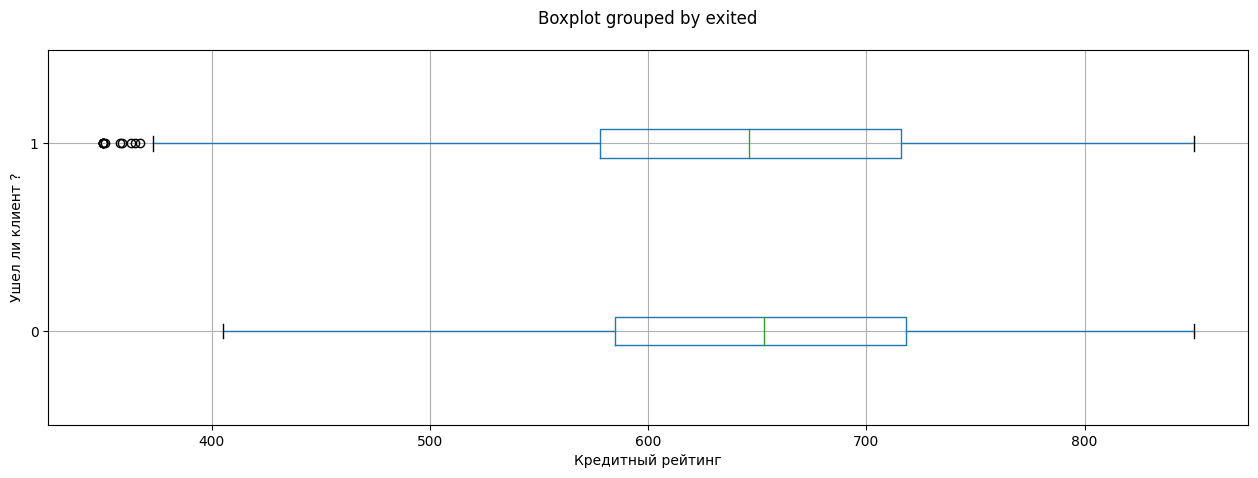

In [ ]:
#Диаграмма размаха для кредитного рейтинга
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Диаграмма размаха для кредитного рейтинга', fontsize=14, fontweight='bold', y = 0.95);
data.boxplot(column = ['credit_score'], rot= 0, figsize = (15,5), vert = False, by = 'exited', ax = axes, backend = None);
axes.set(xlabel = 'Кредитный рейтинг', ylabel = 'Ушел ли клиент ?', title = '');

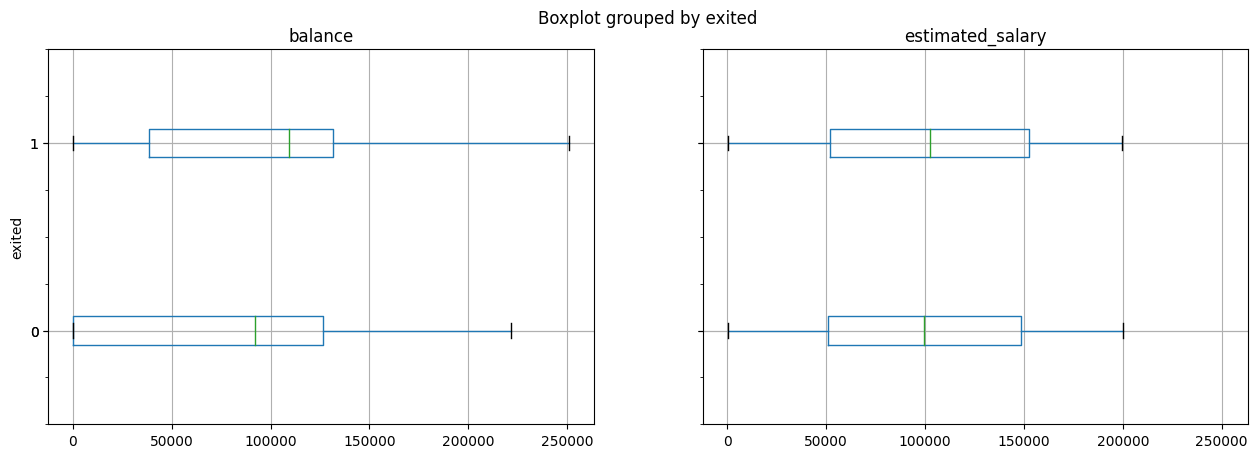

In [ ]:
#Диаграммы размаха для баланса и дохода
data.boxplot(column = ['balance', 'estimated_salary'],figsize = (15, 5), vert = False, by = 'exited');

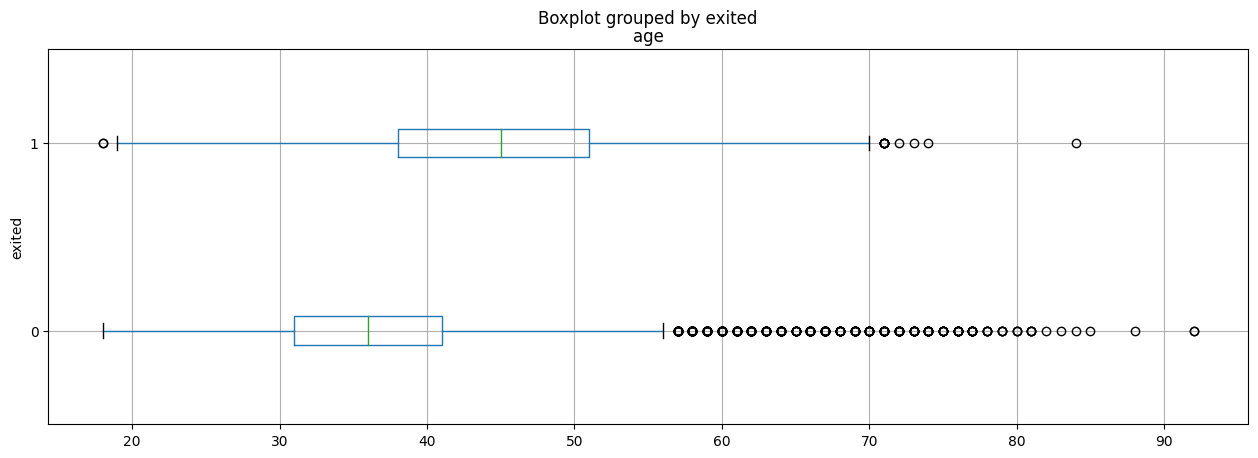

In [ ]:
#Диаграммы размаха для возраста 
data.boxplot(column = ['age'],figsize = (15, 5), vert = False, by = 'exited');

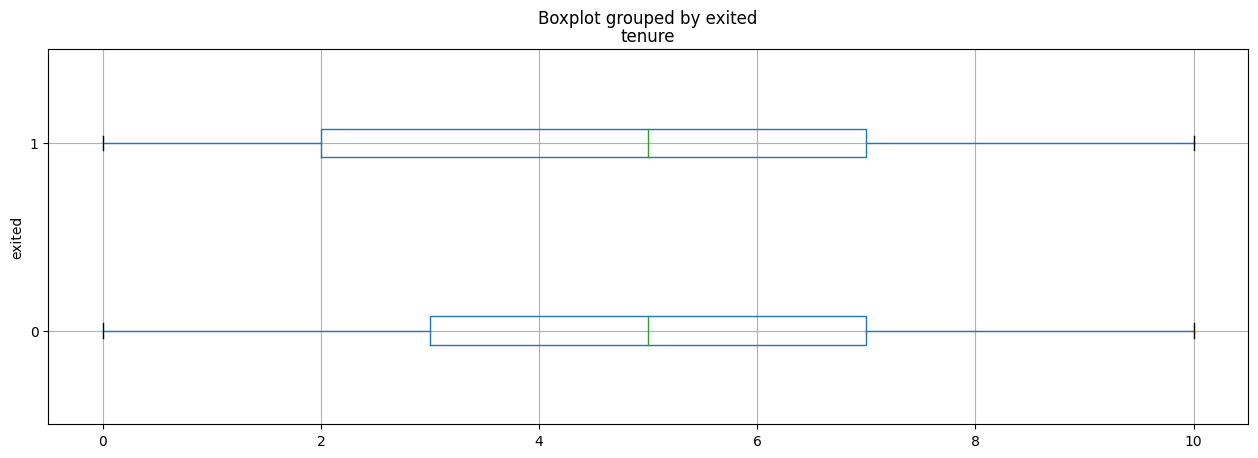

In [ ]:
#Диаграммы размаха для длительности жизненного цикла
data.boxplot(column = ['tenure'],figsize = (15, 5), vert = False, by = 'exited');

В целом все числовые столбцы содержат данные в ожидаемых диапазонах без значительных выбросов и аномальных значений. При этом есть возможность отметить, что чаще из банка уходят:
- клиенты с балансом выше медианного по выборке
- более возрастные клиенты.

### Удаление лишних столбцов

Удалим лишние (не информативные) для исследования столбцы: row_number, customer_id 

In [ ]:
data = data.drop(columns = ['row_number', 'customer_id', 'surname'])

Оценим степень корреляции между столбцами ДФ c с помощью матрицы рассеяния и тепловой карты

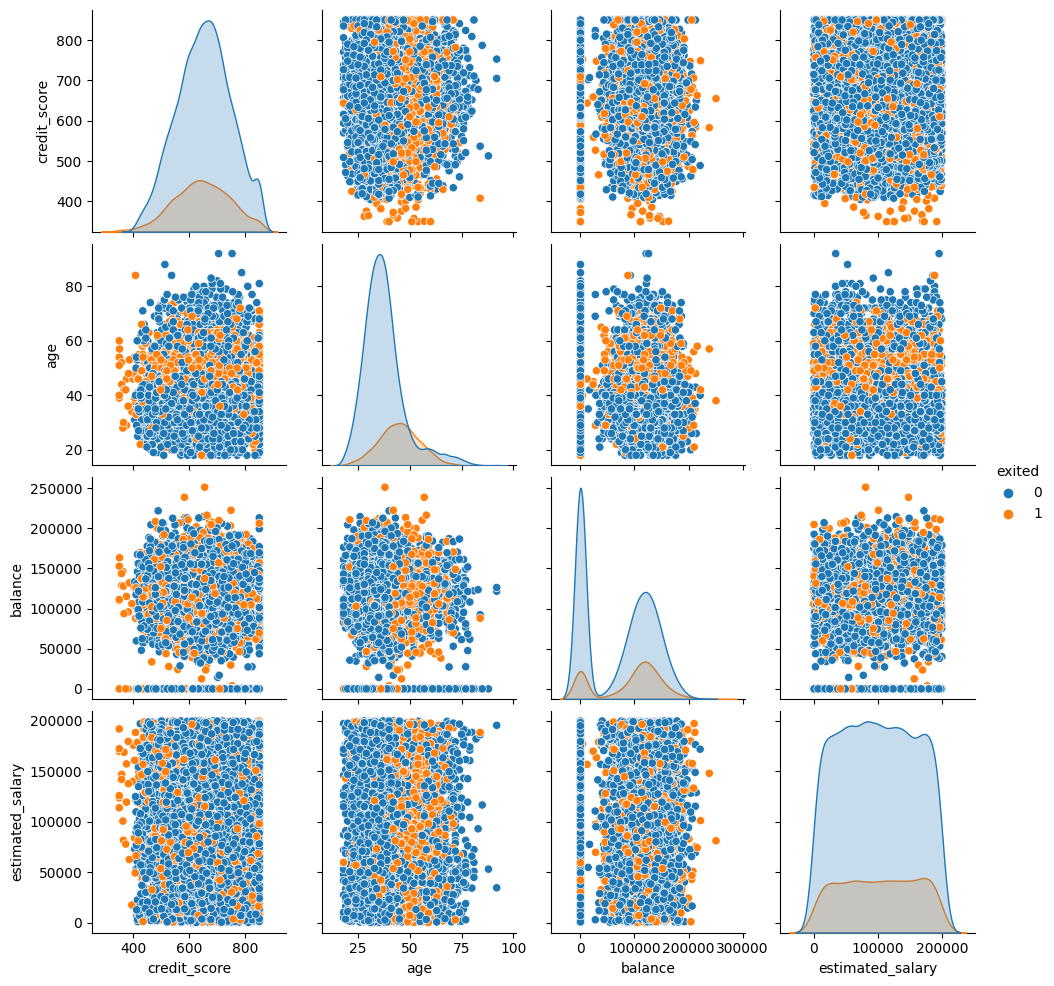

In [ ]:
#Матрица рассеяния
numeric = ['credit_score', 'age', 'balance', 'estimated_salary', 'exited']
sns.pairplot(data.loc[:, numeric], hue = 'exited');

<Axes: >

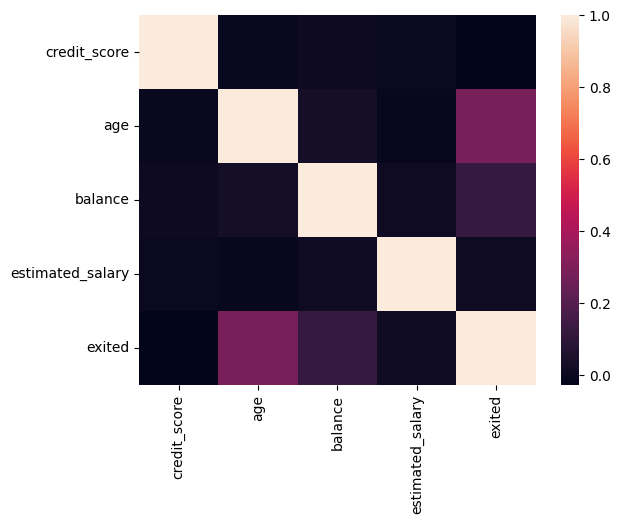

In [ ]:
#Тепловая карта корреляции
sns.heatmap(data[numeric].corr())

В ДФ нет столбцов, сильно коррелированных друг с другом.

### Замена категоральных столбцов числовыми значениями (кодирование)

Так как все категориальные столбцы, которые подлежат кодированию содержат одно из двух возможных значений (1 или 0) из вполнее можно закодировать методом get_dummies  

In [ ]:
data = pd.get_dummies(data, drop_first=True)

### Выделение признаков и целевого признака

In [ ]:
#Выделение признаков и цели
features = data.drop(columns = ['exited'], axis = 0)
target = data.exited

## Исследование данных на предмет применимости для машинного обучения
  - изучение признаков и целевых показателей
  - исследование балланса классов
  - исключение дсбаланса 
     - за счет добавления значений
     - за счет уменьшения значений 
  - масштабирование (нормализация) данных 

### Изучение признаков и целевых показателей

Соотношение количества False записей записям True равно: 3.9091801669121256


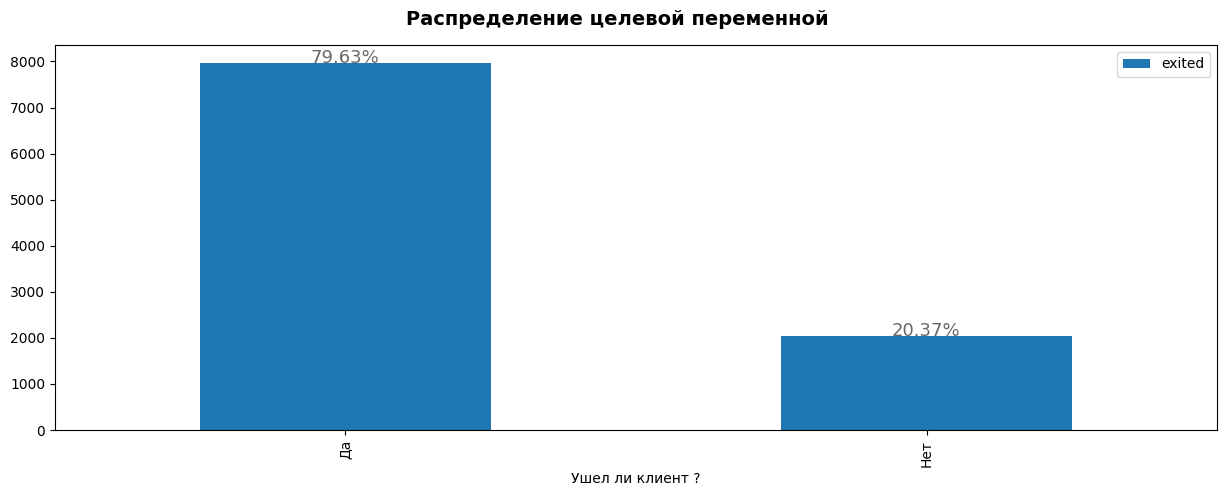

In [ ]:
drow_target_bar(target)

Очевидно в целевои признаке наблюдается сильный дисбаланс со смещением в сторону False значений.

In [ ]:
#Сравнение масштабов данных в числовых столбцах
numerics = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
not_numerics = ['exited', 'geography_Germany', 'geography_Spain', 'gender_Male', 'has_cr_card', 'is_active_member']

#Медианные значения числовых признаков 
print([data[column].mean() for column in numerics])

[650.5288, 38.9218, 4.993004501315241, 76485.889288, 1.5302, 100090.239881]


Очевидно, что числовые признаки имеют колоссально отличающиеся друг от друга масштабы. Для того чтобы повысить скорость и качество машинного обучения нормализуем числовые признаки, но после разбиения выборки на тренировочную и тестовую.


In [ ]:
#Разбиение ДФ на выборки
features_learning, features_test, target_learning, target_test = \
train_test_split(features, target, test_size = 0.20, random_state = 56789)

#Разделение обучающей выборки на тренировочную и валидационную
features_train, features_valid, target_train, target_valid = \
train_test_split(features_learning, target_learning, test_size = 0.25, random_state = 56789)

print(features_train.shape, target_train.shape, \
      features_valid.shape, target_valid.shape,\
      features_test.shape, target_test.shape)


(6000, 11) (6000,) (2000, 11) (2000,) (2000, 11) (2000,)


In [ ]:
#Нормализация данных
#Объект нормализатора
scaler = preprocessing.MinMaxScaler()

#Нормализация тренировочной выборки
norm_features_train = features_train.copy()
norm_features_train[numerics]= scaler.fit_transform(features_train[numerics]) 

#Нормализация "закрытых" выборок
norm_features_test = features_test.copy()
norm_features_test[numerics]= scaler.transform(features_test[numerics]) 

norm_features_valid = features_test.copy()
norm_features_valid[numerics]= scaler.transform(features_valid[numerics]) 

In [ ]:
norm_features_train.head(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
68,0.622,0.229730,0.5,0.632271,0.333333,0,1,0.568111,1,0,0
8597,0.568,0.472973,0.3,0.477296,0.333333,1,1,0.531534,1,0,0
2370,0.258,0.229730,0.2,0.474397,0.000000,1,0,0.978276,0,0,0
3384,0.850,0.648649,0.9,0.000000,0.333333,1,1,0.337826,0,0,0
1438,0.308,0.513514,0.9,0.437176,0.000000,0,0,0.278973,1,0,1


### Исключение дисбаланса

#### Исключение дисбаланса за счет клонирования выборки

(5931744,) (5931744, 11)
Соотношение количества False записей записям True равно: 0.0008019246190858059


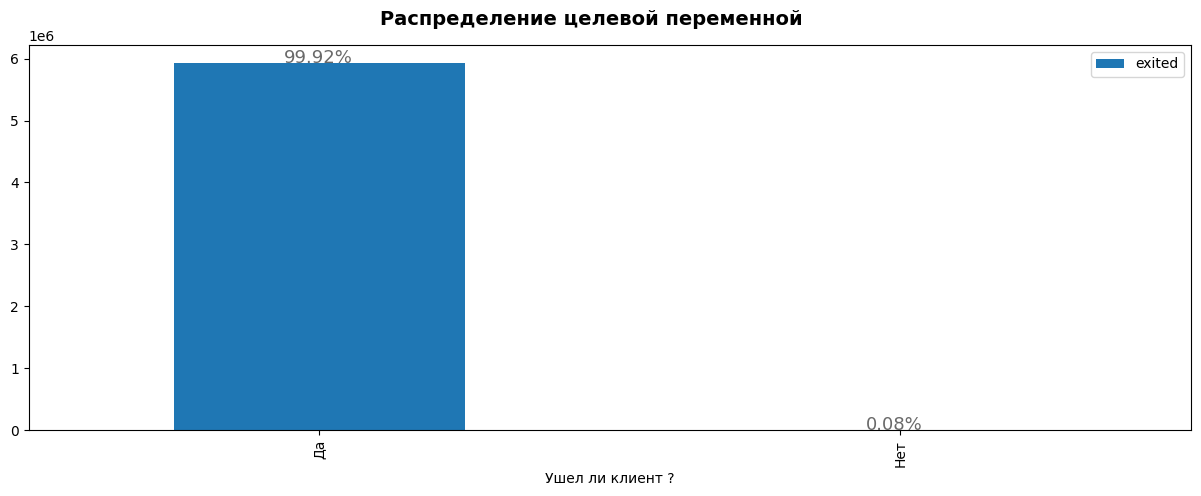

In [ ]:
#Расчет дисбаланса
disbalance = target_train.value_counts()[0]/target_train.value_counts()[1]

#Определение нулевого и единичного целевых векторов
target_train_zero = target_train[target_train == 0]
target_train_one = target_train[target_train == 1]

#Определение нулевого и единичного фреймов с признаками
features_train_zero = features_train.loc[target_train == 0]
features_train_one = features_train.loc[target_train == 1]

#Клонируем вектора и фреймы и объединяем обратно в выборку признаков и целевой series
balance_target_train = pd.concat([target_train_zero] + [target_train_one]*round(len(target_train_one)*disbalance))
balance_features_train = pd.concat([features_train_zero] + [features_train_one]*round(len(target_train_one)*disbalance))

#Перемешиваем полученную выборку
balance_features_train, balance_target_train = shuffle(\
balance_features_train, balance_target_train, random_state = 56789)

#Контролируем форму получившегося ДФ
print(balance_target_train.shape, balance_features_train.shape)

#Контроль дисбаланса
#Распределение значений целевого показателя
df = pd.DataFrame(balance_target_train.value_counts(), index = balance_target_train.value_counts().index)
drow_target_bar(balance_target_train);

#### Исключение дисбаланса за счет уменьшения выборки

(2494,) (2494, 11)
Соотношение количества False записей записям True равно: 1.0


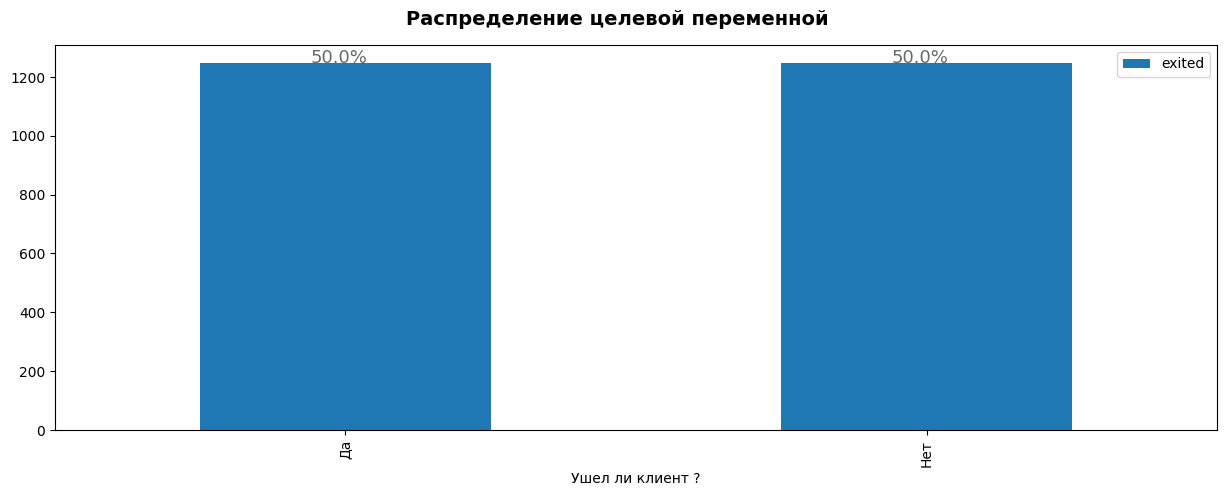

In [ ]:
#Выделем нулевой и единичный целевые вектора
target_train_zero = target_train[target_train == 0]
target_train_one = target_train[target_train == 1]

#Выделем нулевой и единичный фреймы признаков
features_train_zero = features_train.loc[target_train == 0]
features_train_one = features_train.loc[target_train == 1]

#Клонируем вектора и фреймы и объединяем обратно в выборку признаков и целевой series
dbalance_target_train = pd.concat([target_train_zero.sample(len(target_train_one))] + [target_train_one])
dbalance_features_train = pd.concat([features_train_zero.sample(len(target_train_one))] + [features_train_one])

#Перемешиваем полученную выборку
dbalance_features_train, dbalance_target_train = shuffle(\
dbalance_features_train, dbalance_target_train, random_state = 56789)

#Контролируем форму получившегося ДФ
print(dbalance_target_train.shape, dbalance_features_train.shape)

#Контроль дисбаланса
#Распределение значений целевого показателя
df = pd.DataFrame(dbalance_target_train.value_counts(), index = dbalance_target_train.value_counts().index)
drow_target_bar(dbalance_target_train);

### Примечание
Случайно удалить или добавить N примеров одного из классов - это самая простая и примитивная стратегия, понятная и несложная в реализации. Однако такой подход зачастую бывает не совсем эффективным. Предпочтительно сделать стратегию балансировки классов более управляемой, то есть выполняемой в соответствии с некоторыми правилами, например используя заложенные в модели машинного обучения алгоритмы балансировки или задавая при обучении моделей весовые коэффициенты. Но так как в данном учебном проекте ставилась задача реализовать указанные алгоритмы борьбы с дисбалансом, то они реализованы.


## Машинное обучение с учителем
   - обучение модели без учета дисбаланса
   - обучение модели с учетом дисбаланса
   - обучение разных вариантов моделей с учетом дисбаланса
   - выбор лучшей модели на основании метрик (F1-мера, AUC-ROC)
   - финальное тестирование 
   - сравнение метрик, полученных на тестовой с заданным пороговым значением
   - итоговые выводы

In [ ]:
#Формируем словарь для отчета
list_of_models = [LinearDiscriminantAnalysis, KNeighborsClassifier, GaussianNB,\
                  DecisionTreeClassifier, RandomForestClassifier, LogisticRegression,]
list_of_metrics = ['f1_train_up', 'f1_valid_up', 'auc_train_up', 'auc_valid_up', 
                   'f1_train_du', 'f1_valid_du', 'auc_train_du', 'auc_valid_du',
                   'f1_train_db', 'f1_valid_db', 'auc_train_db', 'auc_valid_db', 
                   'f1_test', 'auc_test']

report = {}
for model in list_of_models:
    report[model] = {metric: None for metric in list_of_metrics}

### Обучение моделей 
- модель LinearDiscriminantAnalysis
- модель KNeighborsClassifier
- модель GaussianNB
- модель DecisionTreeClassifier (решающее дерево)
- модель RandomForestClassifier (случайный лес)
- модель LogisticRegression (лог-регрессия)

Для подбора параметров лучшей модели будем использовать авторскую функцию, которая подбирает параметры по валидационной выборке для модели, обученной на тренирововчной выборке, то есть выбирает лучшей ту модель, которая из всех обученных на тренирововчных данных получила лучший результат на валидационной (простенький аналог GridSearch с кросс-валидацией по 2 фолдам)

#### Обучение моделей  по выборке без дисбаланса (получен через upsampling)

##### Модель DecisionTreeClassifier

In [ ]:

#Поиск лучшей модели типа DecisionTreeClassifier самописной функцией
(model_uDT, params_uDT) = find_best_model(DecisionTreeClassifier, 
                        balance_features_train, balance_target_train, 
                        features_valid, target_valid,\
                        'valid_up', report,\
                         **{'random_state': 1945,\
                            'max_features': ['sqrt', 'log2'],\
                            'criterion': ['gini', 'entropy',],\
                            'splitter': ['best', 'random'],\
                            'max_depth': list(range(1, 20, 2)), 
                            'min_samples_split': [2, 3, 4, 5], \
                            'min_samples_leaf': [1, 2, 3, 4]});


100%|██████████| 1280/1280 [4:45:37<00:00, 13.39s/it]

Лучщая модель исследуемого метода : <class 'sklearn.tree._classes.DecisionTreeClassifier'> показала эффективность (f1):
    - на проверочной выборке 0.5,
    - на тренировочной выборке 1.0 с параметрами {'random_state': 1945, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 3} 


#####  Модель LinearDiscriminantAnalysis

In [ ]:
#Лучшая модель типа LinearDiscriminantAnalysis (по параметрам самописной функции)
(model_uLD, params_uLD) = find_best_model(LinearDiscriminantAnalysis, \
                        balance_features_train, balance_target_train,\
                        features_valid, target_valid,\
                        'valid_up', report,\
                         **{});


#### Модель KNeighborsClassifier

In [ ]:

#Поиск лучшей модели типа KNeighborsClassifier "самописным" способом по валидационной выборке
(model_uKN, params_uKN) = find_best_model(KNeighborsClassifier, \
                        balance_features_train, balance_target_train,\
                        features_valid, target_valid,\
                        'valid_up', report,\
                         **{'random_state': 1945,\
                            'n_neighbors': list(range(1, 5)), 
                            'leaf_size': list(range(1, 10, 2)), \
                            'p': [1, 2, 3, 4, 5],
                            });


'\n#Поиск лучшей модели типа KNeighborsClassifier "самописным" способом по валидационной выборке\n(model_uKN, params_uKN) = find_best_model(KNeighborsClassifier,                         balance_features_train, balance_target_train,                        features_valid, target_valid,                        \'valid_up\', report,                         **{\'random_state\': 1945,                            \'n_neighbors\': list(range(1, 5)), \n                            \'leaf_size\': list(range(1, 10, 2)),                             \'p\': [1, 2, 3, 4, 5],\n                            });\n'

##### Модель GaussianNB

In [ ]:
#Лучшая модель типа GaussianNB (по параметрам самописной функции)
(model_uGN,params_uGN) = find_best_model(GaussianNB, \
                        balance_features_train, balance_target_train,\
                        features_valid, target_valid,\
                        'valid_up', report,\
                         **{});

0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 35.88it/s]

Лучщая модель исследуемого метода : <class 'sklearn.naive_bayes.GaussianNB'> показала эффективность (f1):
    - на проверочной выборке 0.536,
    - на тренировочной выборке 0.654 с параметрами {} 


##### LogisticRegression

In [ ]:
#Поиск лучшей модели типа LogisticRegression самописной функцией
(model_uLR,params_uLR) = find_best_model(LogisticRegression,
                        balance_features_train, balance_target_train,
                        features_valid, target_valid,\
                        'valid_up', report,\
                         **{'random_state': 1945,\
                            'solver': ['newton-cg','lbfgs','liblinear','sag','saga'], \
                            'max_iter': list(range(1, 100, 5))});


"\n#Поиск лучшей модели типа LogisticRegression самописной функцией\n(model_uLR,params_uLR) = find_best_model(LogisticRegression,\n                        balance_features_train, balance_target_train,\n                        features_valid, target_valid,                        'valid_up', report,                         **{'random_state': 1945,                            'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],                             'max_iter': list(range(1, 100, 5))});\n"

##### RandomForestClassifier

In [ ]:

#Поиск лучшей модели типа RandomForestClassifier самописной функцией
(model_uRF,params_uRF) = find_best_model(RandomForestClassifier,
                        balance_features_train, balance_target_train,
                        features_valid, target_valid,\
                        'valid_up', report,\
                         **{'random_state': 1113,
                            'n_estimators': list(range(50, 100, 10)),
                            'max_depth': list(range(1, 10, 1)),
                            'min_samples_split': [2, 3, 4, 5],
                            'min_samples_leaf': [1, 2, 3, 4]});


"\n#Поиск лучшей модели типа RandomForestClassifier самописной функцией\n(model_uRF,params_uRF) = find_best_model(RandomForestClassifier,\n                        balance_features_train, balance_target_train,\n                        features_valid, target_valid,                        'valid_up', report,                         **{'random_state': 1113,\n                            'n_estimators': list(range(50, 100, 10)),\n                            'max_depth': list(range(1, 10, 1)),\n                            'min_samples_split': [2, 3, 4, 5],\n                            'min_samples_leaf': [1, 2, 3, 4]});\n"

#### Выводы по результатам обучения моделей на выборке без дисбаланса (получена через upsampling)

In [ ]:
#Вывод результатов  
data_report = {model: list(metrics.values()) for model, metrics in report.items()}
report_df = pd.DataFrame.from_dict(data_report, orient='index')
report_df.columns = list_of_metrics
display(report_df)

,f1_train_up,f1_valid_up,auc_train_up,auc_valid_up,f1_train_du,f1_valid_du,auc_train_du,auc_valid_du,f1_train_db,f1_valid_db,auc_train_db,auc_valid_db,f1_test,auc_test
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>,0.640768,0.516129,0.759281,0.788633,None,None,None,None,None,None,None,None,None,None
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>,0.921202,0.460460,1.000000,0.697917,None,None,None,None,None,None,None,None,None,None
<class 'sklearn.naive_bayes.GaussianNB'>,0.654139,0.535750,0.784031,0.808046,None,None,None,None,None,None,None,None,None,None
<class 'sklearn.tree._classes.DecisionTreeClassifier'>,0.706250,0.576832,0.841376,0.820303,None,None,None,None,None,None,None,None,None,None
<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.843486,0.621359,0.948420,0.850283,None,None,None,None,None,None,None,None,None,None
<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.640802,0.514048,0.758799,0.788826,None,None,None,None,None,None,None,None,None,None


Судя по полученным результатам можно сделать следующие выводы:
1. Несмотря на принятые меры все модели склонны к переобучению
2. Наиболее склонна к переобучению модель KNeighborsClassifier (осуществляет поиск по ближайшим соседям
3. Благодяра балансировке все модели на тренировочной выборке достигли f1, большей 0.59
4. На валидационной выборке сохранилf f1, большую 0.59 одна модель RandomForestClassifier и с небольшим отставанием DecisionTreeClassifier
5. Значения auc-roc также самые оптимальные у указанных моделей.
6. Из интересного: на тренировочной выборке самые лучщие результаты были достигнуты с моделью KNeighborsClassifier (auc-roc = 1). Но найти способ хоть как-то сохранить такие показатели для валидационной выборки не  удалось.

Проверим, какие показатели будут у перечисленных моделей на сбалансированной методом исключения выборке.


#### Обучение моделей  по выборке без дисбаланса (получен через downsampling)

In [ ]:
#Поиск лучшей модели типа DecisionTreeClassifier самописной функцией
(model_dDT, params_dDT) = find_best_model(DecisionTreeClassifier, 
                        dbalance_features_train, dbalance_target_train, 
                        features_valid, target_valid,\
                        'valid_du', report,\
                         **{'random_state': 1173,
                            'max_features': ['auto', 'sqrt', 'log2'],\
                            'criterion': ['gini', 'entropy',],\
                            'splitter': ['best', 'random'],\
                            'max_depth': list(range(1, 20)), 
                            'min_samples_split': [2, 3, 4, 5], \
                            'min_samples_leaf': [1, 2, 3, 4, 5]});


"\n#Поиск лучшей модели типа DecisionTreeClassifier самописной функцией\n(model_dDT, params_dDT) = find_best_model(DecisionTreeClassifier, \n                        dbalance_features_train, dbalance_target_train, \n                        features_valid, target_valid,                        'valid_du', report,                         **{'random_state': 1173,\n                            'max_features': ['auto', 'sqrt', 'log2'],                            'criterion': ['gini', 'entropy',],                            'splitter': ['best', 'random'],                            'max_depth': list(range(1, 20)), \n                            'min_samples_split': [2, 3, 4, 5],                             'min_samples_leaf': [1, 2, 3, 4, 5]});\n"

In [ ]:
#Лучшая модель типа LinearDiscriminantAnalysis (по параметрам самописной функции)
(model_dLD, params_dLD) = find_best_model(LinearDiscriminantAnalysis, \
                        dbalance_features_train, dbalance_target_train,\
                        features_valid, target_valid,\
                        'valid_du', report,\
                         **{});

0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

Лучщая модель исследуемого метода : <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> показала эффективность (f1):
    - на проверочной выборке 0.506,
    - на тренировочной выборке 0.69 с параметрами {} 


In [ ]:

#Поиск лучшей модели типа KNeighborsClassifier "самописным" способом по валидационной выборке
(model_dKN, params_dKN) = find_best_model(KNeighborsClassifier, \
                        dbalance_features_train, dbalance_target_train,\
                        features_valid, target_valid,\
                        'valid_du', report,\
                         **{'random_state': 1949,
                            'n_neighbors': list(range(1, 5)), 
                            'leaf_size': list(range(1, 10, 2)), \
                            'p': [1, 2, 3, 4, 5],
                            });


'\n#Поиск лучшей модели типа KNeighborsClassifier "самописным" способом по валидационной выборке\n(model_dKN, params_dKN) = find_best_model(KNeighborsClassifier,                         dbalance_features_train, dbalance_target_train,                        features_valid, target_valid,                        \'valid_du\', report,                         **{\'random_state\': 1949,\n                            \'n_neighbors\': list(range(1, 5)), \n                            \'leaf_size\': list(range(1, 10, 2)),                             \'p\': [1, 2, 3, 4, 5],\n                            });\n'

In [ ]:
#Лучшая модель типа GaussianNB (по параметрам самописной функции)
(model_dGN,params_dGN) = find_best_model(GaussianNB, \
                        dbalance_features_train, dbalance_target_train,\
                        features_valid, target_valid,\
                        'valid_du', report,\
                         **{});

0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 54.48it/s]

Лучщая модель исследуемого метода : <class 'sklearn.naive_bayes.GaussianNB'> показала эффективность (f1):
    - на проверочной выборке 0.512,
    - на тренировочной выборке 0.709 с параметрами {} 


In [ ]:

#Поиск лучшей модели типа LogisticRegression самописной функцией
(model_dLR,params_dLR) = find_best_model(LogisticRegression,
                        dbalance_features_train, dbalance_target_train,
                        features_valid, target_valid,\
                        'valid_du', report,\
                         **{'random_state': 1943,
                            'solver': ['newton-cg','lbfgs','liblinear','sag','saga'], \
                            'max_iter': list(range(1, 200, 10))});


"\n#Поиск лучшей модели типа LogisticRegression самописной функцией\n(model_dLR,params_dLR) = find_best_model(LogisticRegression,\n                        dbalance_features_train, dbalance_target_train,\n                        features_valid, target_valid,                        'valid_du', report,                         **{'random_state': 1943,\n                            'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],                             'max_iter': list(range(1, 200, 10))});\n"

In [ ]:
#Поиск лучшей модели типа LogisticRegression самописной функцией
(model_dLR,params_dLR) = find_best_model(LogisticRegression,
                        dbalance_features_train, dbalance_target_train,
                        features_valid, target_valid,\
                        'valid_du', report,\
                         **{'random_state': 1943,
                            'solver': 'sag', \
                            'max_iter': 21});

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._logistic.LogisticRegression'> показала эффективность (f1):
    - на проверочной выборке 0.504,
    - на тренировочной выборке 0.693 с параметрами {'random_state': 1943, 'solver': 'sag', 'max_iter': 21} 


In [ ]:

#Поиск лучшей модели типа RandomForestClassifier самописной функцией
(model_dRF,params_dRF) = find_best_model(RandomForestClassifier,
                        dbalance_features_train, dbalance_target_train,
                        features_valid, target_valid,\
                        'valid_du', report,\
                         **{'random_state': 1083,
                            'n_estimators': list(range(50, 100, 10)),
                            'max_depth': list(range(1, 10, 1)),
                            'min_samples_split': [2, 3, 4, 5],
                            'min_samples_leaf': [1, 2, 3, 4]});


"\n#Поиск лучшей модели типа RandomForestClassifier самописной функцией\n(model_dRF,params_dRF) = find_best_model(RandomForestClassifier,\n                        dbalance_features_train, dbalance_target_train,\n                        features_valid, target_valid,                        'valid_du', report,                         **{'random_state': 1083,\n                            'n_estimators': list(range(50, 100, 10)),\n                            'max_depth': list(range(1, 10, 1)),\n                            'min_samples_split': [2, 3, 4, 5],\n                            'min_samples_leaf': [1, 2, 3, 4]});\n"

#### Выводы по результатам обучения моделей на выборке без дисбаланса (получена через downsampling)

In [ ]:
#Вывод результатов  
data_report = {model: list(metrics.values()) for model, metrics in report.items()}
report_df = pd.DataFrame.from_dict(data_report, orient='index')
report_df.columns = list_of_metrics
display(report_df)

,f1_train_up,f1_valid_up,auc_train_up,auc_valid_up,f1_train_du,f1_valid_du,auc_train_du,auc_valid_du,f1_train_db,f1_valid_db,auc_train_db,auc_valid_db,f1_test,auc_test
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>,0.640768,0.516129,0.759281,0.788633,0.690020,0.506173,0.762058,0.787690,None,None,None,None,None,None
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>,0.921202,0.460460,1.000000,0.697917,0.837095,0.456110,0.916829,0.723644,None,None,None,None,None,None
<class 'sklearn.naive_bayes.GaussianNB'>,0.654139,0.535750,0.784031,0.808046,0.708766,0.511504,0.785613,0.804418,None,None,None,None,None,None
<class 'sklearn.tree._classes.DecisionTreeClassifier'>,0.706250,0.576832,0.841376,0.820303,0.737143,0.498701,0.825716,0.787152,None,None,None,None,None,None
<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.843486,0.621359,0.948420,0.850283,0.847039,0.585462,0.931989,0.851462,None,None,None,None,None,None
<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.640802,0.514048,0.758799,0.788826,0.692683,0.503923,0.761426,0.787284,None,None,None,None,None,None


Судя по полученным результатам можно сделать следующие выводы:
1. Качество моделей по сравнению с теми, которые были обучены на выборке, сбалансированной с помощью клонирования снизилось (где-то на 0.05 пунктов для f1)
2. Метрика auc-roc оказалась менее зависимой от типа балансировки выборки и снизилась в среднем на 0.01 пункт.
2. На валидационной выборке даже RandomForestClassifier не достигла f1, большей 0.59.
3. Остальные тенденции, отмеченные для выборки, полученной клонированием сохранились.

Проверим, какие показатели будут у перечисленных моделей на не сбалансированной выборке.

#### Обучение моделей  по выборке с дисбалансом

In [ ]:

#Поиск лучшей модели типа DecisionTreeClassifier самописной функцией
(model_DT, params_DT) = find_best_model(DecisionTreeClassifier, 
                        features_train, target_train, 
                        features_valid, target_valid,\
                        'valid_db', report,\
                         **{'random_state': 1121,
                            'max_features': ['auto', 'sqrt', 'log2'],\
                            'criterion': ['gini', 'entropy',],\
                            'splitter': ['best', 'random'],\
                            'max_depth': list(range(1, 20)), 
                            'min_samples_split': [2, 3, 4, 5], \
                            'min_samples_leaf': [1, 2, 3, 4, 5]});


"\n#Поиск лучшей модели типа DecisionTreeClassifier самописной функцией\n(model_DT, params_DT) = find_best_model(DecisionTreeClassifier, \n                        features_train, target_train, \n                        features_valid, target_valid,                        'valid_db', report,                         **{'random_state': 1121,\n                            'max_features': ['auto', 'sqrt', 'log2'],                            'criterion': ['gini', 'entropy',],                            'splitter': ['best', 'random'],                            'max_depth': list(range(1, 20)), \n                            'min_samples_split': [2, 3, 4, 5],                             'min_samples_leaf': [1, 2, 3, 4, 5]});\n"

In [ ]:

#Поиск лучшей модели типа RandomForestClassifier самописной функцией
(model_RF,params_RF) = find_best_model(RandomForestClassifier,
                        features_train, target_train,\
                        features_valid, target_valid,\
                        'valid_db', report,\
                         **{'random_state': 1054,
                            'n_estimators': list(range(50, 100, 10)),
                            'max_depth': list(range(1, 10, 1)),
                            'min_samples_split': [2, 3, 4, 5],
                            'min_samples_leaf': [1, 2, 3, 4]});


"\n#Поиск лучшей модели типа RandomForestClassifier самописной функцией\n(model_RF,params_RF) = find_best_model(RandomForestClassifier,\n                        features_train, target_train,                        features_valid, target_valid,                        'valid_db', report,                         **{'random_state': 1054,\n                            'n_estimators': list(range(50, 100, 10)),\n                            'max_depth': list(range(1, 10, 1)),\n                            'min_samples_split': [2, 3, 4, 5],\n                            'min_samples_leaf': [1, 2, 3, 4]});\n"

#### Выводы по результатам обучения моделей на выборке c дисбалансом (не обработанная выборка)

In [ ]:
#Вывод результатов  
data_report = {model: list(metrics.values()) for model, metrics in report.items()};
report_df = pd.DataFrame.from_dict(data_report, orient = 'index');
report_df.columns = list_of_metrics;


,f1_train_up,f1_valid_up,auc_train_up,auc_valid_up,f1_train_du,f1_valid_du,auc_train_du,auc_valid_du,f1_train_db,f1_valid_db,auc_train_db,auc_valid_db,f1_test,auc_test
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>,0.640768,0.516129,0.759281,0.788633,0.690020,0.506173,0.762058,0.787690,NaN,NaN,NaN,NaN,None,None
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>,0.921202,0.460460,1.000000,0.697917,0.837095,0.456110,0.916829,0.723644,NaN,NaN,NaN,NaN,None,None
<class 'sklearn.naive_bayes.GaussianNB'>,0.654139,0.535750,0.784031,0.808046,0.708766,0.511504,0.785613,0.804418,NaN,NaN,NaN,NaN,None,None
<class 'sklearn.tree._classes.DecisionTreeClassifier'>,0.706250,0.576832,0.841376,0.820303,0.737143,0.498701,0.825716,0.787152,0.711600,0.497159,0.930025,0.719654,None,None
<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.843486,0.621359,0.948420,0.850283,0.847039,0.585462,0.931989,0.851462,0.646266,0.578352,0.931581,0.845380,None,None
<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.640802,0.514048,0.758799,0.788826,0.692683,0.503923,0.761426,0.787284,NaN,NaN,NaN,NaN,None,None


Судя по полученным результатам можно сделать следующие выводы:
1. Качество моделей по сравнению с теми, которые были обучены на сбалансированных выборках, значительно снизилось (где-то на 0.08-0.09 пунктов для f1)
2. Метрика auc-roc оказалась менее зависимой от типа балансировки выборки и снизилась в среднем на 0.01 пункт.
3. Ни одна модель на валидационной выборке не достигла f1, большей 0.59.

Таким образом, лучщие метрики качества были достигнуты при балансировке выборки путем клонирования. Посмотрим, можно ли улучшить метрики моделей на несбалансированной выборке путем изменения порога

### Подбор порога для лучшей модули

In [ ]:
#DecisionTreeClassifier
(lim, f1) = calc_limit(model_DT, features_train, target_train)
print("Подобранный порог равен ", lim,"Значение f1 меры с порогом составило", f1)
(lim, f1) = calc_limit(model_DT, features_valid, target_valid)
print("Подобранный порог равен ", lim,"Значение f1 меры с порогом составило", f1)

0.36 0.7243243243243243
0.23 0.5249457700650759


In [ ]:
#RandomForestClassifier
(lim, f1) = calc_limit(model_RF, features_train, target_train)
print("Подобранный порог равен ", lim,"Значение f1 меры с порогом составило", f1)
(lim, f1) = calc_limit(model_RF, features_valid, target_valid)
print("Подобранный порог равен ", lim,"Значение f1 меры с порогом составило", f1)

0.32 0.7332214765100672
0.37 0.6269503546099291


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined a

Метод подбора порога принятия решения для борьбы с несбалансированной выборкой показал очень неплохую эффективность на модели RandomForestClassifier. f1-мера на валидационной выборке увеличилась с 0.56 до 0.62

## Тестирование модели

#### DecisionTreeClassifier

In [ ]:
#Лучшая модель типа DecisionTreeClassifier (по параметрам самописной функции) тестовой выборке
find_best_model(DecisionTreeClassifier, \
                balance_features_train,  balance_target_train,\
                features_test, target_test,\
                'test', report,\
                **params_uDT);

100%|██████████| 1/1 [00:00<00:00, 24.64it/s]

Лучщая модель исследуемого метода : <class 'sklearn.tree._classes.DecisionTreeClassifier'> показала эффективность (f1):
    - на проверочной выборке 0.576,
    - на тренировочной выборке 0.706 с параметрами {'random_state': 1945, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2} 


#### RandomForestClassifier

In [ ]:
#Поиск лучшей модели типа RandomForestClassifier самописной функцией
find_best_model(RandomForestClassifier,
                        balance_features_train,  balance_target_train,\
                        features_test, target_test,\
                        'test', report,\
                         **params_uRF);

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Лучщая модель исследуемого метода : <class 'sklearn.ensemble._forest.RandomForestClassifier'> показала эффективность (f1):
    - на проверочной выборке 0.653,
    - на тренировочной выборке 0.843 с параметрами {'random_state': 1113, 'n_estimators': 80, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1} 


In [ ]:
#Вывод результатов  
data_report = {model: list(metrics.values()) for model, metrics in report.items()};
report_df = pd.DataFrame.from_dict(data_report, orient = 'index');
report_df.columns = list_of_metrics;
display(report_df);

,f1_train_up,f1_valid_up,auc_train_up,auc_valid_up,f1_train_du,f1_valid_du,auc_train_du,auc_valid_du,f1_train_db,f1_valid_db,auc_train_db,auc_valid_db,f1_test,auc_test
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>,0.640768,0.516129,0.759281,0.788633,0.690020,0.506173,0.762058,0.787690,NaN,NaN,NaN,NaN,NaN,NaN
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>,0.921202,0.460460,1.000000,0.697917,0.837095,0.456110,0.916829,0.723644,NaN,NaN,NaN,NaN,NaN,NaN
<class 'sklearn.naive_bayes.GaussianNB'>,0.654139,0.535750,0.784031,0.808046,0.708766,0.511504,0.785613,0.804418,NaN,NaN,NaN,NaN,NaN,NaN
<class 'sklearn.tree._classes.DecisionTreeClassifier'>,0.706250,0.576832,0.841376,0.820303,0.737143,0.498701,0.825716,0.787152,0.711600,0.497159,0.930025,0.719654,0.575723,0.835657
<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.843486,0.621359,0.948420,0.850283,0.847039,0.585462,0.931989,0.851462,0.646266,0.578352,0.931581,0.845380,0.653349,0.896292
<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.640802,0.514048,0.758799,0.788826,0.692683,0.503923,0.761426,0.787284,NaN,NaN,NaN,NaN,NaN,NaN


После тестирования моделей осталась одна, соответствующая заданному условию качества - RandomForestClassifier c метриками:
f1: 0.653
auc-roc: 0.89

## Выводы по результатам проекта

Целью исследования было найти машинную модель, которая на основании исследования исторических данных о поведении клиентов и расторжении договоров с банком предсказывает, уйдёт клиент из банка в ближайшее время или нет. 
Показателем качества модели требовалось принять F1-меру, которую необходимо было довести до значения не меньше 0.59. Также требовался дополнительный контроль метрики AUC-ROC. 

В процесе исследования:
1. Загружены и изучены данные о клиентах банка
2. Загруженные данные оценены, определена их форма, типы, смысловая нагрузка
3. Выполнена предобработка, включая:
     - проверку и переименование названий столбцов (приведение к стилю under_score)
     - проверку корректности назначенных типов данных (некорректных назначений не выявлено)
     - поиск полных и неявных дубликатов (не выявлено) 
     - поиск и заполнение пропусков (найдены и заполнены медианными значениями схожих записей пропуски в столбце tenure c контролем статистических характеристик изменяемого признака)
     - выявление аномальных значений (не выявлено)
     - удаление неинформативных столбцов, затрудняющих обучение моделей ('row_number', 'customer_id', 'surname')
     - поиск коррелированных столбцов (не выявлено)
     - кодирование категориальных переменных (geography, gender)
4. Проведено исследование данных на предмет применимости для машинного обучения
  - изучены признаки (credit_score, geography, gender, age, tenure, balance, num_of_products, has_cr_card, is_active_member, estimated_salary) и целевые показатели (exited)
  - проведена нормализация количественных признаков методом preprocessing.MinMaxScaler
  - выполнено разбиение данных на тренировочную, валидационную и тестовую выборки
  - исследован баланс классов (выявлен дисбаланс в сторону Negative(0) значений целевого признака)
  - использовано два метода исключения дисбаланса данных
     - за счет добавления значений (клонирование записей с 1 целевым признаком)
     - за счет уменьшения количества значений (отбрасывание записей с 0 целевым признаком)
5. Подготовлен комплект функций, автоматизирующих:
 - перебор гиперпараметров моделей
 - возвращающих лучшую модель, где лучшей считается модель с наивысшим значением f1-меры на валидационной выборке
 - расчет и сохранение получившихся метрик модели в словаре - отчете

6. Проведено машинное обучение с учителем на моделях классификации:
- модель LinearDiscriminantAnalysis
- модель KNeighborsClassifier
- модель GaussianNB
- модель DecisionTreeClassifier (решающее дерево)
- модель RandomForestClassifier (случайный лес)
- модель LogisticRegression (лог-регрессия)

7. Выполнено:
   - обучение всех моделей на сбалансированной методом клонирования выборке
   - обучение всех моделей на сбалансированной методом отбрасывания выборке
   - обучение двух наиболее оптимальных моделей (DecisionTreeClassifier, RandomForestClassifier) на несбалансированной выборке
   - подбор порога принятия решения на несбалансированной выборке для двух наиболее оптимальных моделей (DecisionTreeClassifier, RandomForestClassifier), позволивший добиться f1-мера: 0.62 для несбалансированных данных на модели RandomForestClassifier
   - выбрана лучшая модель на основании метрик (F1-мера, AUC-ROC): RandomForestClassifier
   - финальное тестирование лучшей модели, в процессе которого достигнуты f1-мера: 0.653, auc-roc: 0.89 
   
8. По результатам обучения и сравнения моделей можно отметить следующее.
   1. Несмотря на принятые меры все модели на всех выборках склонны к переобучению
   2. Наиболее склонна к переобучению модель KNeighborsClassifier (осуществляет поиск по ближайшим соседям
   3. Применение балансировки методом клонирования позволяет добиться наилучщих показателей качества моделей (f1-мера)
   4. Метрика f1-мера очень сильно зависит от сбалансированности данных
   5. Метрика auc-roc менее зависима от типа балансировки выборки (различия между сбалансированной и не сбалансированной выборкой менее 0.02 пунктов).
   6. Из интересного: на тренировочной выборке самые лучшие результаты были достигнуты с моделью KNeighborsClassifier (auc-roc = 1). Но найти способ хоть как-то сохранить такие показатели для валидационной выборки не  удалось.
   
Все параметры и объекты обученных моделей зафиксированы в датафрейме report_df  